# Lab 3: CNNs and Deep Learning

## TBMI26/732A55 Neural Networks and Learning Systems

### Michael Felsberg

## 2D Convolution
For the further steps, we often need to visualize an image and we define a shortcut for that:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

def visualize(img):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.show()
    print('Image size:', img.shape)

Convolution can be performed in 2D using the function `scipy.signal.convolve2d()`.  

**Task 1:** Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $h$ with itself, starting with $h = \begin{array}{|c|c|}
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
      \frac{1}{4} & \frac{1}{4} \\
      \hline
    \end{array}$. Visualize the kernel.

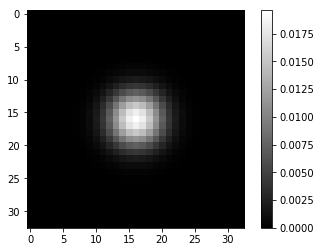

Image size: (33, 33)


In [2]:
import numpy as np
import scipy
from scipy import signal

h = np.asarray([[0.25, 0.25], [0.25, 0.25]])
for i in range(5):
    h = signal.convolve2d(h, h)
visualize(h)

**Task 2:** Now, load the image 'MR15^044.JPG' (a sample from ImageNet), convert it to gray-scale by summing its  R-, G-, and B-values at each pixel, and normalize it to the interval $[0;1]$. Convolve it with $h$ from the previous task with the options `'valid'` and `'same'`. Visualize all three images. What differences do you observe regarding the size and intensity of the output?

/opt/TBMI26/2019-02-20.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


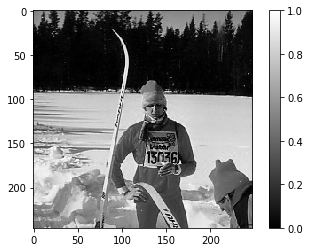

Image size: (246, 248)


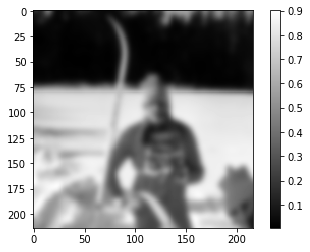

Image size: (214, 216)


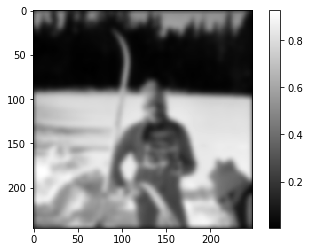

Image size: (246, 248)


In [3]:
from scipy import misc
image = misc.imread('MR15^044.JPG')
image = np.sum(image, 2)
image -= np.min(image)
image = image/np.max(image)

image_convolved_valid = signal.convolve2d(image, h, mode = 'valid')
image_convolved_same = signal.convolve2d(image, h, mode = 'same')

visualize(image)
visualize(image_convolved_valid)
visualize(image_convolved_same)

> In both cases, the image has been blurred. However, when using "valid" we don't use zero-padding, meaning that the image will shrink. When using "same", zero-padding is allowed, which means there is some blurring with "darkness" (0) at the edges of the image.

Strided convolution removes samples. According to the Nyquist theorem, this can generate aliasing artifacts.  

**Task 3:** Visualize the original gray-scale image and the output image from the previous task (with option `'same'`) with only keping every fifth row and column (stride 5). What do you observe, in particular at the ski?

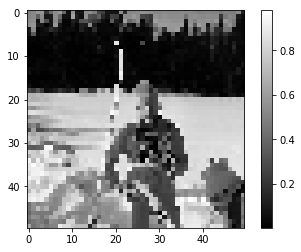

Image size: (50, 50)


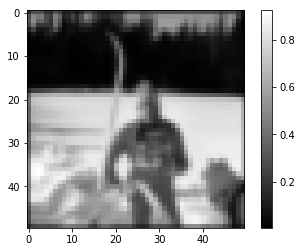

Image size: (50, 50)


In [4]:
visualize(image[::5,::5])
visualize(image_convolved_same[::5,::5])

> The previously convolved image is much smoother. At the ski particularly, the strided original is choppy an lacking parts of the ski, while in the blurred image the ski still appears complete. Since data is "blurred" to the nearby pixels, data regarding the ski will also affect the intensity of closeby pixels.

## Convolution  in TensorFlow
We will now repeat the same steps in TensorFlow, where we will exploit its capability to perform *eager execution*. This is initialized as follows:

In [5]:
import tensorflow as tf

print('TensorFlow version '+tf.__version__)
tf.enable_eager_execution()
if tf.executing_eagerly():
    print('Eager execution activated!')

TensorFlow version 1.9.0
Eager execution activated!


TensorFlow allows to map from and to numpy. Also, operations are automatically casted. In order to get used to TensorFlow and the casting, we repeat the convolution 1.a) from class 5 (see Lisam). As you have learned in the lecture, any convolution with kernel $h$ can also be performed as matrix multiplication by the Toeplitz matrix $H$.

**Task 4:**  Use `scipy.linalg.toeplitz` to generate the matrix $H$ for the kernel $h= \begin{array}{|c|c|c|}
      \hline
      \hphantom{-}1 & \hphantom{-}\textbf{2} & -2 \\
      \hline
    \end{array}$ and boundary condition `'same'` and $f= \begin{array}{|c|c|c|c|c|c|c|c|}
      \hline
      \hphantom{-}1 & -1 & -2 & \hphantom{-}\textbf{0} & -1 & \hphantom{-}1 & \hphantom{-}2 & -1 \\
      \hline
    \end{array}$ in TensorFlow (`tf.constant()`). Multiply $H$ and $f$ and display the result. Verify that the result is the same as in 1.a). What are the respective classes of $H$, $f$, and the result?  
    Hints: `scipy.linalg.toeplitz` can take the first column and row as input; `[*np.zeros()]=np.zeros()` (`*` dereferences all elements of a tuple) 

In [6]:
from scipy import linalg

f = [1, -1, -2, 0, -1, 1, 2, -1]
tinyh = [1, 2, -2]
H = tf.constant(linalg.toeplitz(tinyh[1:] + list(np.zeros(len(f))), tinyh[1::-1] + list(np.zeros(len(f)))))
f = tf.constant([0] + f + [0], dtype = tf.float64, shape=(10,1))
print(f)
print(H)
print(tf.matmul(H, f))
#print(h[1:], list(np.zeros(len(f))))

tf.Tensor(
[[ 0.]
 [ 1.]
 [-1.]
 [-2.]
 [ 0.]
 [-1.]
 [ 1.]
 [ 2.]
 [-1.]
 [ 0.]], shape=(10, 1), dtype=float64)
tf.Tensor(
[[ 2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-2.  2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -2.  2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -2.  2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -2.  2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -2.  2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -2.  2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -2.  2.]], shape=(10, 10), dtype=float64)
tf.Tensor(
[[ 1.]
 [ 1.]
 [-6.]
 [-2.]
 [ 3.]
 [-1.]
 [ 6.]
 [ 1.]
 [-6.]
 [ 2.]], shape=(10, 1), dtype=float64)


Keras layers can be applied in eager mode using the `tf.keras.layers` package. **NOTE:**  `tf.keras.layers` and **NOT** `keras.layers`.

**Task 5:** Perform the convolution from the previous task using a convolution layer `Conv1D` and a (trivial) `Sequential` model from `tf.keras`.  
Hints: RTFM of `tf.keras.Sequential` - weights can be set for the model (list) or the layer (by traversing the layers list). Apply `use_bias=False` to avoid random DC-shifts.

In [7]:
f = np.asarray([0, 1, -1, -2, 0, -1, 1, 2, -1, 0])
tinyh = np.asarray([1, 2, -2])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(1, 3, use_bias = False, padding = 'same', input_shape = (8, 1)))
model.layers[0].set_weights(np.asarray([[[[i]] for i in tinyh[::-1]]]))
output = model.predict(np.asarray([np.ndarray.transpose(np.asarray([f]))]))
print(output[0])

[[ 1.]
 [ 1.]
 [-6.]
 [-2.]
 [ 3.]
 [-1.]
 [ 6.]
 [ 1.]
 [-6.]
 [ 2.]]


**Task 6:** Apply the cascaded $33\times33$ filter from task 1 to the image from task 2 using a `Conv2D` layer. Compare the result visually and by subtracting the fitting result from task 2.

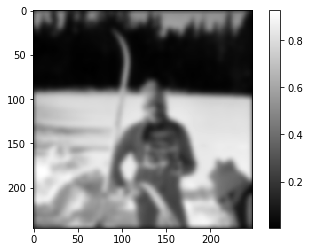

Image size: (246, 248)


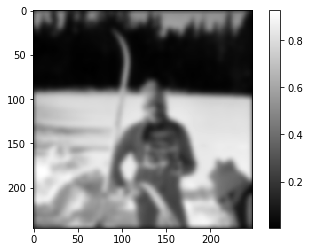

Image size: (246, 248)


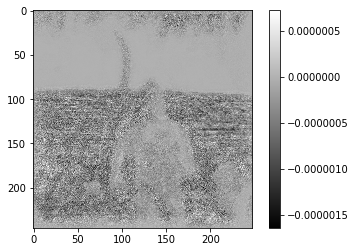

Image size: (246, 248)
7.232594060324615e-07


In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(1, 33, use_bias = False, padding = 'same', input_shape = (image.shape[0], image.shape[1], 1)))
model.layers[0].set_weights(np.asarray([h.reshape(33, 33, 1, 1)]))
task6_output = model.predict(np.asarray([image.reshape(246, 248, 1)])) #We have to add a z-dimension

visualize(task6_output[0].reshape(246, 248))
visualize(image_convolved_same)
visualize(task6_output[0].reshape(246, 248) - image_convolved_same)
print(np.max(task6_output[0].reshape(246, 248) - image_convolved_same))


> The two images are extremely similar with tiiiny differences. These differences are within the expected margin of error for floats.

**Task 7:** Repeat the previous task with stride 5 and compare the result visually and by subtracting the fitting result from task 3. Repeat the task, but with a $1\times1$ filter (coefficient `1`) and stride 5. Compare again the result visually and by subtracting the fitting result from task 3.  
Hint: You might need to adjust the offset for the subsampling.

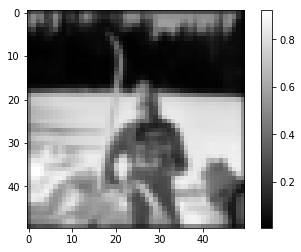

Image size: (50, 50)


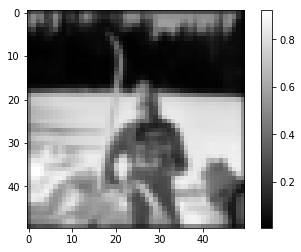

Image size: (50, 50)


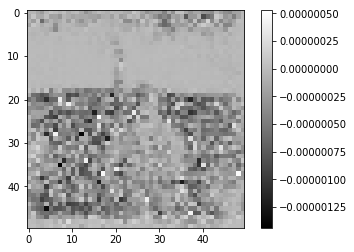

Image size: (50, 50)
5.277521147872832e-07


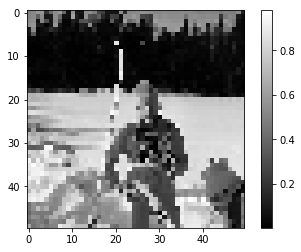

Image size: (50, 50)


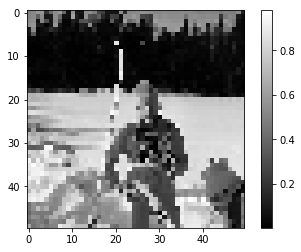

Image size: (50, 50)


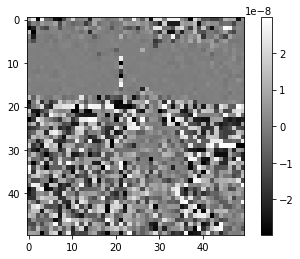

Image size: (50, 50)
2.976326296533216e-08


In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(1, 33, strides = (5, 5), use_bias = False, padding = 'same', input_shape = (image.shape[0], image.shape[1], 1)))
model.layers[0].set_weights(np.asarray([h.reshape(33, 33, 1, 1)]))
output = model.predict(np.asarray([image.reshape(246, 248, 1)]))

visualize(output[0].reshape(50, 50))
_ = image_convolved_same[::5,1::5] #So there seems to be some off-set here. Likely that tensorflow tries to center convolution?
visualize(_)
visualize(output[0].reshape(50, 50) - _)
print(np.max(output[0].reshape(50, 50) - _))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(1, 1, strides = 5, use_bias = False, padding = 'same', input_shape = (image.shape[0], image.shape[1], 1)))
model.layers[0].set_weights(np.asarray([[[[[1]]]]]))
output = model.predict(np.asarray([image.reshape(246, 248, 1)]))

visualize(output[0].reshape(50, 50))
visualize(image[::5,::5])
visualize(output[0].reshape(50, 50) - image[::5,::5])
print(np.max(output[0].reshape(50, 50) - image[::5,::5]))


We now define a new filter that is, unlike $h$, anti-symmetric:

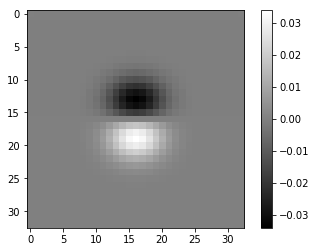

Image size: (33, 33)


In [10]:
fsz = 33
hfsz = 17
g = h*(np.expand_dims(np.arange(-hfsz+1,hfsz),1)@np.ones((1,fsz)))
visualize(g)

**Task 8:** repeat tasks 6 & 7 with $g$ instead of $h$. What difference do you observe and why?

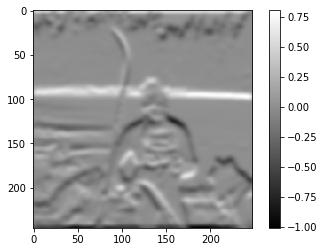

Image size: (246, 248)


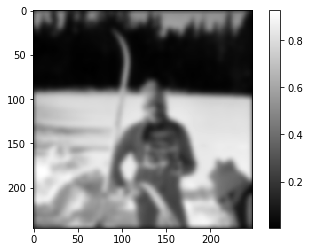

Image size: (246, 248)


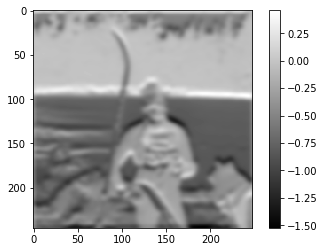

Image size: (246, 248)
0.45778845577489496


In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(1, 33, use_bias = False, padding = 'same', input_shape = (image.shape[0], image.shape[1], 1)))
model.layers[0].set_weights(np.asarray([g.reshape(33, 33, 1, 1)]))
output = model.predict(np.asarray([image.reshape(246, 248, 1)])) #We have to add a z-dimension

visualize(output[0].reshape(246, 248))
visualize(image_convolved_same)
visualize(output[0].reshape(246, 248) - image_convolved_same)
print(np.max(output[0].reshape(246, 248) - image_convolved_same))

> This new convolution does not only blur the image, but because of its assymmetry it also detects contrasts. As the plane of assymmetry is horizontal, it will detect horizontal edges of contrast. Subtracting the normally convoluted image from it yields a negative image with horizontal edges highlighted.

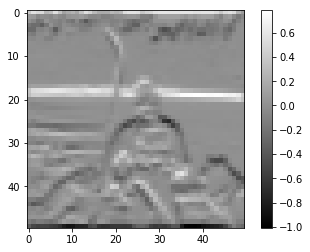

Image size: (50, 50)


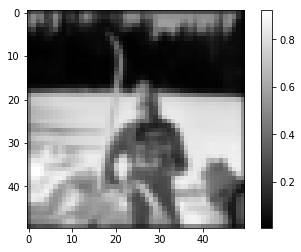

Image size: (50, 50)


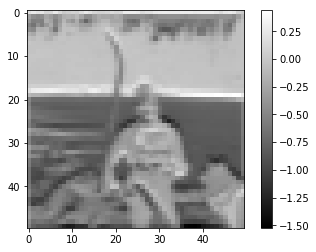

Image size: (50, 50)
0.4388551876369269


In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(1, 33, strides = (5, 5), use_bias = False, padding = 'same', input_shape = (image.shape[0], image.shape[1], 1)))
model.layers[0].set_weights(np.asarray([g.reshape(33, 33, 1, 1)]))
output = model.predict(np.asarray([image.reshape(246, 248, 1)]))

visualize(output[0].reshape(50, 50))
_ = image_convolved_same[::5,1::5] #So there seems to be some off-set here...
visualize(_)
visualize(output[0].reshape(50, 50) - _)
print(np.max(output[0].reshape(50, 50) - _))


## Training layers
We now take the input and output from task 6 as training data (input and output) for supervised learning of a convolution layer.  
**Task 9:** Although we only have a single input and output image, we can expect the training to work, although this usually requires multiple samples. Why? Define two tensors `batch` and `label` that contain the data from task 6.

> This is a simple rule to learn, requiring only one singe layer of weights, and we have more data than weights to learn (roughly 250 times 250 pixels and only 33 times 33 weights). There is no noise which can mess this up.

In [13]:
batch = tf.constant(np.asarray([image.reshape(image.shape[0], image.shape[1], 1)]), dtype = tf.float32)
label = tf.constant(task6_output, dtype = tf.float32)

**Task 10:** We want to apply the L1-loss. Define a suitable function `loss(model, x, y)` that can be used during training.

In [14]:
def loss(model, x, y):
    error = y - model(x)
    return tf.reduce_mean(tf.abs(error))

Training a layers requires computing the gradient. For TF in eager mode, we use `GradientTape()` for this purpose.  
**Task 11:** Train the model from task 6 (but without assigning the weights) using the data from task 9, the loss from task 10, and `GradientDescentOptimizer()`. During training, print the loss every 100 steps and visualize the learned kernel after training.  
Hint: add a kernel_constraint to be non-negative.

In [15]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(1, 33, use_bias = False, kernel_constraint = tf.keras.constraints.NonNeg(), padding = 'same', input_shape = (image.shape[0], image.shape[1], 1)))

optimizer = tf.train.GradientDescentOptimizer(0.001)
train_steps = 2000
steps_to_record = 100
loss_value = 0
del loss_value
recorded_losses = [None]*int(train_steps/steps_to_record)
for i in range(train_steps):
    with tf.GradientTape(persistent = True) as tape:
        loss_value = loss(model, batch, label)
    dw = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(dw, model.variables))
    if i%steps_to_record == 0:
        print(loss_value.numpy())
        recorded_losses[int(i/steps_to_record)] = loss_value.numpy()
        
output = model.predict(batch)


0.37876177
0.0902351
0.03602776
0.10687212
0.109377384
0.11429837
0.11756325
0.119584136
0.121019155
0.12181002
0.122006446
0.122142605
0.12221211
0.12235706
0.12240254
0.12237674
0.12238797
0.12235759
0.12233616
0.12231685


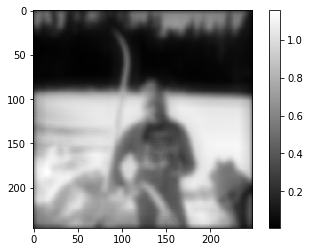

Image size: (246, 248)


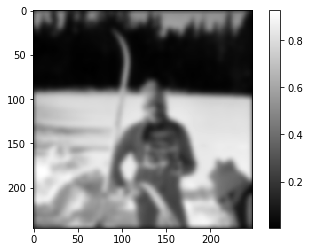

Image size: (246, 248)


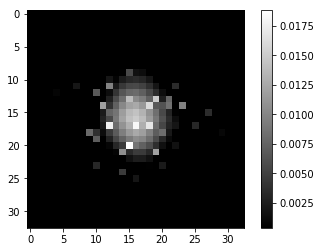

Image size: (33, 33)


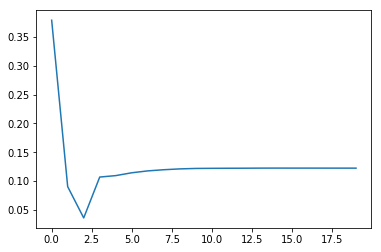

In [16]:
visualize(output[0].reshape(output.shape[1], output.shape[2]))
visualize(task6_output[0].reshape(246, 248))
visualize(np.asarray(model.layers[0].get_weights()[0]).reshape(33, 33))
plt.plot(range(len(recorded_losses)), recorded_losses)
plt.show()

The result can be improved in several ways: data augmentation (e.g. by flipping the image, using the three RGB-channel separately), regularizing the weights (e.g. using the L1-norm), and replacing the optimizer (e.g., ADAM).  
**Extra task (not to be done before task 14 is completed):** Try to improve the result using one or several of the mentioned approaches.

## Training a whole network
So far, we have been training a single layer and we have been following the progress with the help of the Eager mode. If we want to train a whole network, it is much better to leave the Eager mode and to compile the graph. For this, we need to kill the notebook kernel ("Kernel" -> "Restart"). After that, we continue below in the classical TensorFlow mode.  

In [2]:
import tensorflow as tf
print('TensorFlow version '+tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

TensorFlow version 1.9.0


**Task 12:** We will train on CIFAR10, which is contained in `keras.datasets`. Download the dataset, show a sample for each class, convert the labels to one-hot coding, and normalize the images.

Label: 0


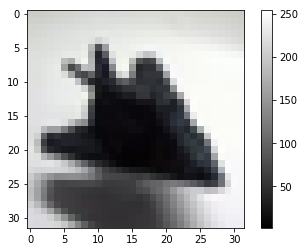

Image size: (32, 32, 3)
Label: 1


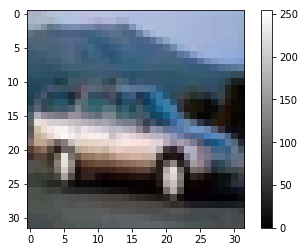

Image size: (32, 32, 3)
Label: 2


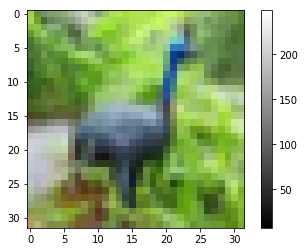

Image size: (32, 32, 3)
Label: 3


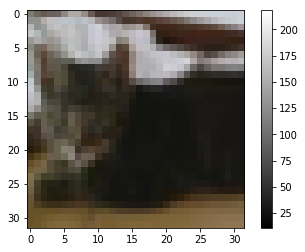

Image size: (32, 32, 3)
Label: 4


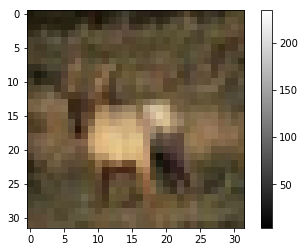

Image size: (32, 32, 3)
Label: 5


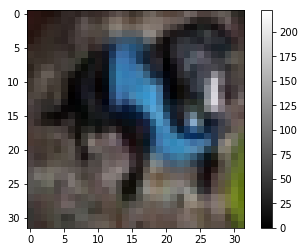

Image size: (32, 32, 3)
Label: 6


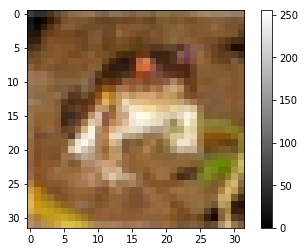

Image size: (32, 32, 3)
Label: 7


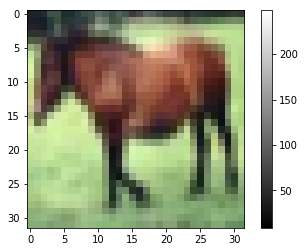

Image size: (32, 32, 3)
Label: 8


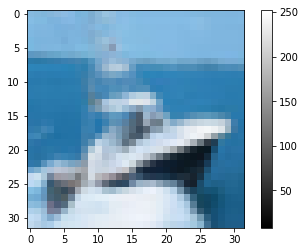

Image size: (32, 32, 3)
Label: 9


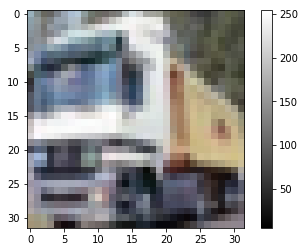

Image size: (32, 32, 3)


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
nr_labels = 10
for i in range(nr_labels):
    for x, y in zip(x_train, y_train):
        if y[0] == i:
            print('Label: {}'.format(i))
            visualize(x)
            break

def one_hot(data, nr_of_labels):
    _ = data.reshape(data.shape[0])
    data = np.zeros((data.shape[0], nr_of_labels))
    data[np.arange(data.shape[0]), _] = 1
    return data
    
y_train = one_hot(y_train, nr_labels)
y_test = one_hot(y_test, nr_labels)
x_train = x_train-np.min(x_train)
x_train = x_train/np.max(x_train)
x_test = x_test-np.min(x_test)
x_test = x_test/np.max(x_test)

**Task 13:** Build the depicted LeNet5-inspired model using Keras standard components.
![title](model.png)

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import Adam, rmsprop
from keras.layers import Activation
from keras import regularizers

num_classes = 10

def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(16, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(8, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3,3), padding='same'))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    opt = Adam(lr=0.001, decay=1e-6)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


Using TensorFlow backend.


We will now train the network. For displaying the performance we define a helper function:

In [5]:
def plot_model_history(model):
    line_w = 3
    fig_size = (8, 6)
    plt.figure(0)
    plt.plot(model.history['acc'],'r', lw=line_w)
    plt.plot(model.history['val_acc'],'b', lw=line_w)
    plt.rcParams['figure.figsize'] = fig_size
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Validation Accuracy")
    plt.legend(['Training','Validation'])
    plt.grid(True)

**Task 14:** Train the defined model for 50 epochs and a suitable batch size and display the result.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 233us/step - loss: 2.1471 - acc: 0.2810 - val_loss: 1.6441 - val_acc: 0.3968
Epoch 2/50
50000/50000 [==============================] - 10s 200us/step - loss: 1.5378 - acc: 0.4311 - val_loss: 1.4218 - val_acc: 0.4857
Epoch 3/50
50000/50000 [==============================] - 10s 201us/step - loss: 1.3431 - acc: 0.5124 - val_loss: 1.2452 - val_acc: 0.5505
Epoch 4/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.2324 - acc: 0.5579 - val_loss: 1.1201 - val_acc: 0.5948
Epoch 5/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.1698 - acc: 0.5805 - val_loss: 1.0669 - val_acc: 0.6186
Epoch 6/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.1287 - acc: 0.5963 - val_loss: 1.0089 - val_acc: 0.6356
Epoch 7/50
50000/50000 [==============================] - 10s 203us/step - loss: 1.0891 - acc: 0.6111 - val_loss: 1.

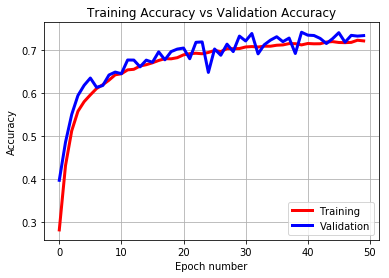

In [6]:
model = base_model()
output_model = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 128, epochs = 50)
plot_model_history(output_model)

The results can be improved in several ways, e.g., by successively reducing the learning rate (divided by two after 30 and 40 epochs), by data augmentation (`ImageDataGenerator`), and by weight regularization (see above).  
**Extra task:** Try to improve the result using one or several of the mentioned approaches.  
Hint: you need to define a suitable callback function to change the learning rate during training.